# Projeto Petrobras

In [78]:
%matplotlib inline
import subprocess
from wordcloud import WordCloud
import unicodedata
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import nltk

In [2]:
def rem_accents(text):
    if type(text) == str:
        text = unicode(text, 'utf8')
    return unicodedata.normalize('NFD', text).encode('ascii', 'ignore') #remove accents

doc_info = dict()
#read capa
#TODO - checar se todo documento tem so uma pagina de capa mesmo (talvez seja mais seguro tirar do texto completo)
capa = rem_accents(subprocess.check_output("pdftotext -l 1 '01.09-2015-  Odebrecht.pdf' -", shell=True))
    
#read rest
text = rem_accents(subprocess.check_output("pdftotext -f 2 '01.09-2015-  Odebrecht.pdf' -", shell=True))

# Get PDF meta-info (from cover)

In [3]:
#date
get_data = r'DATA:\s+(\d\d\/\d\d\/\d\d\d\d)'
res = re.search(get_data, capa, re.M|re.I)
if res:
    doc_info["date"] = res.group(1)
    print("date: {}".format(doc_info["date"]))
else:
    print("date not found in file!")
    
#n_pages
get_n_pages = r'PAGINAS:\s+(\d+)'
res = re.search(get_n_pages, capa, re.M|re.I)
if res:
    doc_info["n_pages"] = int(res.group(1))
    print("n_pages: {}".format(doc_info["n_pages"]))
else:
    print("n_pages not found in file!")


#depoentes_names
#depoentes_roles
re_depoentes_block = r'^DEPOENTE/CONVIDADO - QUALIFICACAO\n((?:.*\n)+)^SUMARIO\s*$'
res = re.search(re_depoentes_block, capa, re.M|re.I)
assert res, ">>>>Big problem: Didn't find names of depoentes!!!"
if res:
    depoentes_block = res.group(1)
    depoentes_names = []
    depoentes_cargos = []
    for l in re.split(r'\.\n', depoentes_block):
        l = l.replace('\n', ' ')
        parts = l.split(" - ")
        if len(parts) >= 2:
            nome = parts[0].strip()
            cargo = "".join(parts[1:]).strip()
            depoentes_names.append(nome)
            depoentes_cargos.append(cargo)
    doc_info["depoentes_names"] = depoentes_names
    doc_info["depoentes_cargos"] = depoentes_cargos
    for el in zip(doc_info["depoentes_names"], doc_info["depoentes_cargos"]):
        print(el)

date: 01/09/2015
n_pages: 77
('CESAR RAMOS ROCHA', 'EX-DIRETOR DA ODEBRECHT')
('ANTONIO NABOR AREIAS BULHOES', 'ADVOGADO')
('ROGERIO SANTOS DE ARAUJO', 'EXECUTIVO DA ODEBRECHT')
('FLAVIA RAHAL BRESSER PEREIRA', 'ADVOGADA')
('MARCIO FARIA DA SILVA', 'DIRETOR DA ODEBRECHT')
('ALEXANDRINO DE SALLES RAMOS DE ALENCAR', 'EX-DIRETOR DA ODEBRECHT')
('MARCELO BAHIA ODEBRECHT', 'PRESIDENTE DA ODEBRECHT')
('CELSO ARARIPE DOLIVEIRA', 'EX-GERENTE DE EMPREENDIMENTOS DA PETROBRAS NO ESPIRITO SANTO')


# Treat the rest of the text

### Clean text

In [4]:
#limpa texto
clean_header = r'CAMARA DOS DEPUTADOS - DETAQ(?:.*\n)*?\d\d\/\d\d\/\d\d\d\d'
clean_num = r'\n\s*\d+\s*\n'
clean_mult_n = r'\n\n+'


#remove headers
text, subs = re.subn(clean_header, "", text, flags=re.M)
print(subs)
assert subs == doc_info["n_pages"], "doing more substitutions than pages!"
    

#remove page numbers
text, subs = re.subn(clean_num, "\n", text, flags=re.M)
print(subs)
assert subs == doc_info["n_pages"], "doing more substitutions than pages!"

#remove double newlines
text, subs = re.subn(clean_mult_n, "", text, flags=re.M)
print(subs)

77
77
27


### Get people phrases

In [41]:
doc_info["text"] = dict()
for depoente in doc_info["depoentes_names"]:
    doc_info["text"][depoente] = dict()
    doc_info["text"][depoente]["falas"] = []
    regex_str = r'^.+{}\s+-\s+(.*\n(?:.*\n)*?)(?:^(?:O\s+SR|A\s+SRA|SR|SRA))'.format(depoente)
    #regex_str = r'^.+{}\s+-\s+(.*\n(?:.*\n)*?)(?:^O\s+SR|A\s+SRA)'.format(depoente)
    frases_regex = re.compile(regex_str, re.M)
    frases = frases_regex.findall(text)
    print("\n>>>>>{}".format(depoente))
    print(len(frases))
    for i,f in enumerate(frases):
        ff = re.sub(r'([^.])\n', r'\1 ', f, flags=re.M)
        ff = ff.strip()
        doc_info["text"][depoente]["falas"].append(ff)
        print("{}: {}".format(i+1, ff))


>>>>>CESAR RAMOS ROCHA
22
1: Bom dia! Nos termos assegurados pelo Supremo, eu vou exercer o direito de permanecer em silencio.
2: Como eu disse, Excelencia, vou permanecer em silencio.
3: Eu vou permanecer em silencio.
4: Eu vou permanecer em silencio.
5: Eu vou permanecer em silencio.
6: Eu vou permanecer em silencio.
7: Eu vou permanecer em silencio.
8: Eu vou permanecer em silencio.
9: Eu vou permanecer em silencio.
10: Eu vou permanecer em silencio.
11: Permanecerei em silencio.
12: Permanecerei em silencio.
13: Permanecei em silencio.
14: Permanecerei em silencio.
15: Permanecerei em silencio.
16: Permanecerei em silencio.
17: Permanecerei em silencio, Excelencia.
18: Permanecerei em silencio.
19: Permanecerei em silencio.
20: Permanecerei em silencio.
21: Eu permanecerei em silencio.
22: Obrigado. Bom dia a todos!

>>>>>ANTONIO NABOR AREIAS BULHOES
3
1: Eminente Presidente, seria possivel V.Exa. me conceder a palavra, por 1 minutinho, para uma questao de ordem?
2: E so para escl

## text_statistics

In [43]:
#each document statistics
for n in doc_info["depoentes_names"]:
    doc_info["text"][n]["n_answers"] = len(doc_info["text"][n]["falas"])
    doc_info["text"][n]["len_char_answers"] = sum(len(f) for f in doc_info["text"][n]["falas"])
    doc_info["text"][n]["avg_len_char_answers"] = doc_info["text"][n]["len_char_answers"] / doc_info["text"][n]["n_answers"]
    doc_info["text"][n]["len_words_answers"] = sum(len(re.split(r'\W+', f)) for f in doc_info["text"][n]["falas"])
    doc_info["text"][n]["avg_len_words_answers"] = doc_info["text"][n]["len_words_answers"] / doc_info["text"][n]["n_answers"]
    doc_info["text"][n]["silence_answers"] = sum(1 if re.search(r'silenci', f, re.I) else 0 for f in doc_info["text"][n]["falas"])
    ## non-silence stats
    doc_info["text"][n]["n_answers_ns"] = doc_info["text"][n]["n_answers"] - doc_info["text"][n]["silence_answers"]
    doc_info["text"][n]["len_char_answers_ns"] = sum(len(f) for f in doc_info["text"][n]["falas"] if not re.search(r'silenci', f, re.I))
    doc_info["text"][n]["avg_len_char_answers_ns"] = doc_info["text"][n]["len_char_answers_ns"] / doc_info["text"][n]["n_answers_ns"]
    doc_info["text"][n]["len_words_answers_ns"] = sum(len(re.split(r'\W+', f)) for f in doc_info["text"][n]["falas"] if not re.search(r'silenci', f, re.I))
    doc_info["text"][n]["avg_len_words_answers_ns"] = doc_info["text"][n]["len_words_answers_ns"] / doc_info["text"][n]["n_answers_ns"]


#general statistics
doc_info["text"]["general"] = dict()
doc_info["text"]["general"]["n_answers"] = sum(doc_info["text"][n]["n_answers"] for n in doc_info["depoentes_names"])
doc_info["text"]["general"]["len_char_answers"] = sum(doc_info["text"][n]["len_char_answers"] for n in doc_info["depoentes_names"])
doc_info["text"]["general"]["avg_len_char_answers"] = doc_info["text"]["general"]["len_char_answers"] / doc_info["text"]["general"]["n_answers"]
doc_info["text"]["general"]["len_words_answers"] = sum(doc_info["text"][n]["len_words_answers"] for n in doc_info["depoentes_names"])
doc_info["text"]["general"]["avg_len_words_answers"] = doc_info["text"]["general"]["len_words_answers"] / doc_info["text"]["general"]["n_answers"]
doc_info["text"]["general"]["silence_answers"] = sum(doc_info["text"][n]["silence_answers"] for n in doc_info["depoentes_names"])
## non-silence stats
doc_info["text"]["general"]["n_answers_ns"] = doc_info["text"]["general"]["n_answers"] - doc_info["text"]["general"]["silence_answers"]
doc_info["text"]["general"]["len_char_answers_ns"] = sum(doc_info["text"][n]["len_char_answers_ns"] for n in doc_info["depoentes_names"])
doc_info["text"]["general"]["avg_len_char_answers_ns"] = doc_info["text"]["general"]["len_char_answers_ns"] / doc_info["text"]["general"]["n_answers_ns"]
doc_info["text"]["general"]["len_words_answers_ns"] = sum(doc_info["text"][n]["len_words_answers_ns"] for n in doc_info["depoentes_names"])
doc_info["text"]["general"]["avg_len_words_answers_ns"] = doc_info["text"]["general"]["len_words_answers_ns"] / doc_info["text"]["general"]["n_answers_ns"]    

print(doc_info["text"]["general"])

{'len_char_answers': 24478, 'avg_len_words_answers_ns': 27, 'avg_len_words_answers': 20, 'len_char_answers_ns': 16042, 'avg_len_char_answers_ns': 160, 'len_words_answers': 4200, 'silence_answers': 109, 'n_answers': 209, 'n_answers_ns': 100, 'avg_len_char_answers': 117, 'len_words_answers_ns': 2784}


In [46]:
doc_info

{'date': '01/09/2015',
 'depoentes_cargos': ['EX-DIRETOR DA ODEBRECHT',
  'ADVOGADO',
  'EXECUTIVO DA ODEBRECHT',
  'ADVOGADA',
  'DIRETOR DA ODEBRECHT',
  'EX-DIRETOR DA ODEBRECHT',
  'PRESIDENTE DA ODEBRECHT',
  'EX-GERENTE DE EMPREENDIMENTOS DA PETROBRAS NO ESPIRITO SANTO'],
 'depoentes_names': ['CESAR RAMOS ROCHA',
  'ANTONIO NABOR AREIAS BULHOES',
  'ROGERIO SANTOS DE ARAUJO',
  'FLAVIA RAHAL BRESSER PEREIRA',
  'MARCIO FARIA DA SILVA',
  'ALEXANDRINO DE SALLES RAMOS DE ALENCAR',
  'MARCELO BAHIA ODEBRECHT',
  'CELSO ARARIPE DOLIVEIRA'],
 'n_pages': 77,
 'text': {'ALEXANDRINO DE SALLES RAMOS DE ALENCAR': {'avg_len_char_answers': 54,
   'avg_len_char_answers_ns': 21,
   'avg_len_words_answers': 8,
   'avg_len_words_answers_ns': 5,
   'falas': ['Muito bom dia! Na condicao em que estou, de acusado  ha um processo penal , o Supremo Tribunal Federal me garantiu o direito de ficar em silencio, e assim permanecerei.',
    'Como ja falei, permanecerei em silencio.',
    'Como eu ja falei 

## Wordcloud

u'bom dia no term assegur pel supr eu vou exerc o direit de permanec em silenci com eu diss excelenc vou permanec em silenci eu vou permanec em silenci eu vou permanec em silenci eu vou permanec em silenci eu vou permanec em silenci eu vou permanec em silenci eu vou permanec em silenci eu vou permanec em silenci eu vou permanec em silenci permanec em silenci permanec em silenci permanec em silenci permanec em silenci permanec em silenci permanec em silenci permanec em silenci excelenc permanec em silenci permanec em silenci permanec em silenci eu permanec em silenci obrig bom dia a tod emin presid ser possi v exa me conced a palavr por 1 minut par uma questa de ord e so par esclarec o verd escop da decisa do supr tribun feder eu o fac tamb em nom do noss emin coleg dr renat de mora grand advog brasil que tamb no acompanh nest assent emin presid o supr tribun feder conced habe corpu com ess final e nao porqu o convoc tenh do que se autoincrimin e que o supr tem a compreensa que foi muit

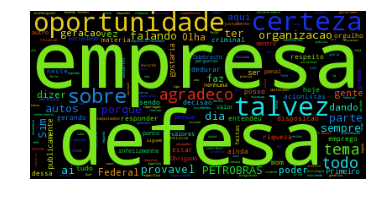

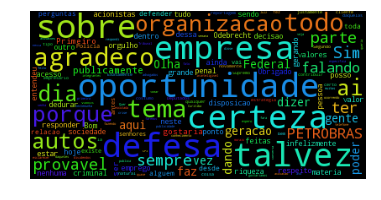

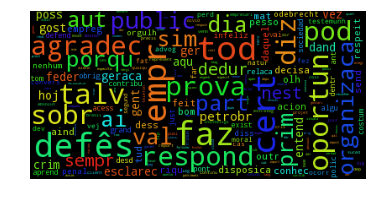

In [101]:
stemmer = nltk.stem.RSLPStemmer()
stemmer.stem("trabalhar")

STOPWORDS = {rem_accents(x) for x in nltk.corpus.stopwords.words('portuguese')} | \
{"sr", "senhor", "deputado", "presidente", "vou", "deputado", "pergunta", "silencio", "permanecer", "permanecerei", "acho", "falei",
 "entao", "processo", "manter", "inclusive", "questao", "momento", "falar", "seguinte"}
STOPWORDS_STEM = {stemmer.stem(x) for x in STOPWORDS}


all_falas = " ".join(f for n in doc_info["depoentes_names"] for f in doc_info["text"][n]["falas"] if not re.search(r'silenci', f, re.I))

all_falas_stem = " ".join(stemmer.stem(w) for w in re.split(r'\W+', all_falas) if w)
wordcloud = WordCloud(stopwords=STOPWORDS, max_font_size=40).generate(all_falas)
plt.imshow(wordcloud)
plt.axis("off")


# wordcloud = WordCloud(max_font_size=40, stopwords=STOPWORDS_STEM).generate(all_falas_stem)
# plt.figure()
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

# The pil way (if you don't have matplotlib)
#image = wordcloud.to_image()
#image.show()        
     

In [8]:


# # Generate a word cloud image
# STOPWORDS = set([rem_accents(x.strip()) for x in open('stopwords-pt.txt').read().split('\n')]) | \
#             {"sr", "senhor", "deputado", "presidente", "vou", }

# wordcloud = WordCloud(stopwords=STOPWORDS).generate(text)

# # Display the generated image:
# # the matplotlib way:
# import matplotlib.pyplot as plt
# plt.imshow(wordcloud)
# plt.axis("off")

# #take relative word frequencies into account, lower max_font_size
# wordcloud = WordCloud(max_font_size=40, stopwords=STOPWORDS).generate(text)#, relative_scaling=.5).generate(text)
# plt.figure()
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

# # The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [9]:
# #see https://github.com/euske/pdfminer/blob/14fd0fd2d6ef4e709731377decc6a8c119e5e9d6/tools/pdf2txt.py for changes
# from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
# from pdfminer.converter import TextConverter
# from pdfminer.layout import LAParams
# from pdfminer.pdfpage import PDFPage
# from cStringIO import StringIO


# def convert_pdf_to_txt(path):
#     rsrcmgr = PDFResourceManager()
#     retstr = StringIO()
#     codec = 'utf-8'
#     laparams = LAParams()
#     device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
#     fp = file(path, 'rb')
#     interpreter = PDFPageInterpreter(rsrcmgr, device)
#     password = ""
#     maxpages = 0
#     caching = True
#     pagenos=set()

#     for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
#         interpreter.process_page(page)

#     text = retstr.getvalue()

#     fp.close()
#     device.close()
#     retstr.close()
#     return text